In [1]:
import matplotlib.pyplot as plt
import numpy as np
import GPy
import pandas as pd
from getdist import plots, MCSamples
import pymultinest
from pymultinest.solve import solve

from gpr4im import fg_tools as fg
from gpr4im import obs_tools as obs

In [2]:
# for plotting:
%matplotlib inline

font = {"size": 16, "family": "STIXGeneral"}
axislabelfontsize = "x-large"
plt.rc("font", **font)
plt.rcParams["text.usetex"] = True

# Nested sampling

In this notebook, we show an example of how to run nested sampling using `pymultinest` for our data. Given a chosen GPR model, nested sampling gives a good estimate for the evidence of your model and also the posteriors of your kernel hyperparameters.

## Loading data

First, we load all the raw data we need for the analysis:

- Foregrounds (with polarisation)
- HI cosmological signal + instrumental noise

And make sure the data is in $[Nx, Ny, Nz]$ format, where $Nz$ is the line of sight (frequency) direction. Our box has dimensions:
- Nx, Ny, Nz = 256, 256, 285
- Lx, Ly, Lz = 1000, 1000, 924.78 Mpc/$h$

The data is smoothed by a constant telescope beam, which is the largest beam given by the beam size at the highest redshift ($z=0.58$). The central redshift of the data is $z=0.39$.

We also load the frequency range of our data, `freqs`. The data goes from 899MHz to 1183MHz in 1MHz increments.

In [3]:
data = pd.read_pickle('../Data/data.pkl')
FGwpol_HI_noise_data = data.beam.FGwpol_HI_noise
freqs = data.freqs

We convert our data to [Npix, Nz] format and mean center each frequency slide:

In [4]:
Input = obs.LoSpixels(FGwpol_HI_noise_data, mean_center=True)

## Setting kernels

Next, we choose what kernels to describe each component of our signal. We choose our initial guesses for the lengthscale and variance of the kernels to be based roughly on what we obtained with the `GPy` gradient descent optimisation.

In [5]:
# kernel for the smooth foreground:
kern_fg_smooth = GPy.kern.RBF(1, variance=60000, lengthscale=400)
# kernel for the polarised foreground:
kern_fg_pol = GPy.kern.RBF(1, variance=0.5, lengthscale=60)
# add foreground kernels together:
kern_fg = kern_fg_smooth + kern_fg_pol
# kernel for the HI cosmological signal:
kern_21 = GPy.kern.Exponential(1, variance=0.001, lengthscale=6)

# adding all kernels together, obtaining our full kernel model:
kern = kern_fg + kern_21

 /opt/anaconda3/envs/testgpr2/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


## Setting up the model

Now we buld our GP model, given our data, our frequency range, and our kernel model. We choose to set the Gaussian noise variance at each frequency to zero, as this was found to be the best model for our data.

In [6]:
model = GPy.models.GPRegression(freqs[:, np.newaxis], Input, kern)
model['.*Gaussian_noise'] = 0.0
model['.*noise'].fix()
ndim = len(model.optimizer_array) # number of kernel hyperparameters

 /opt/anaconda3/envs/testgpr2/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


## Setting prior

We must set the prior for each of our kernel hyperparameters. The prior should transform the unit cube into the parameter cube. In general:

- To translate prior to a 0 to A range: `cube[0] *= A`
- To translate prior to 10^a to 10^b range: `cube[0] = 10**(cube[0]*(b-a) + a)`
- To translate prior to 10^a to b range: `cube[0] = 10**(cube[0]*(log10(b)-a) + a)`
- To translate prior to an a to b range: `cube[0] = 10**( cube[0]*(log10(b)-log10(a) ) + log10(a) )`

Below is our prior function:

In [7]:
def myprior(cube):
    # Smooth foreground RBF variance
    cube[0] = 10**( cube[0]*(np.log10(100000000) - np.log10(1000) ) + np.log10(1000) )
    # Smooth foreground RBF lengthscale
    cube[1] = 10**( cube[1]*(np.log10(10000)-np.log10(200) ) + np.log10(200) )

    # Polarised foreground RBF variance
    cube[2] = 10**( cube[2]*(np.log10(10) - np.log10(0.0001) ) + np.log10(0.0001) )
    # Polarised foreground RBF lengthscale
    cube[3] = 10**( cube[3]*(np.log10(500)-np.log10(15) ) + np.log10(15) )

    # HI signal Exponential variance
    cube[4] = 10**(cube[4]*(np.log10(0.5)-np.log10(0.000001)) + np.log10(0.000001)) 
    # HI signal Exponential lengthscale
    cube[5] = 10**(cube[5]*(np.log10(15)+2) - 2)

    return cube

## Running nested sampling

When running nested sampling, the main results will be saved to a folder. Create the folder called `NS_example` in the appropriate directory in order for this code to work. 

We define our likelihood function below:

In [8]:
def myloglike(cube):
    model['.*var'][0], model['.*var'][1], model['.*var'][2] = cube[0], cube[2], cube[4]
    model['.*len'][0], model['.*len'][1], model['.*len'][2] = cube[1], cube[3], cube[5]

    lnL = model.log_likelihood()

    return lnL

### Important note
The below cell will take ~2 days to run. 

If you **do not** want to run it, you can still run the rest of the notebook since the `NS_example` folder already has pre-computed results in it, just ignore the cell below and run the rest. 

If you **do** want to run it, empty the `NS_example` folder so that your new results can be saved there.

In [9]:
# running nested sampling:
evidence = solve(LogLikelihood = myloglike, Prior = myprior, n_dims = ndim, 
                 outputfiles_basename = 'NS_example/', resume = False, verbose = True)
# save evidence:
np.save('NS_example/evidence_NS_example', evidence)

## Results

Next we will show how to load and understand the results. First, load the summary file:

In [9]:
ev = np.load('NS_example/evidence_NS_example.npy', allow_pickle=True).item()

This file contains your global evidence, accessed as `ev['logZ']`, and the error associated with it, `ev['logZerr']`. The weighted samples of the hypermarameter posteriors are under `ev['samples']`.

A better and more complete way to analyse your nested sampling results is as shown below:

In [10]:
analysis = pymultinest.Analyzer(n_params = ndim, outputfiles_basename = 'NS_example/')

  analysing data from NS_example/.txt


And now doing `analysis.get_stats()` gives you a thorough summary of your results.

In [11]:
stats = analysis.get_stats()

It contains a plethora of information. Of particular interest is the `'global evidence'`, `'global evidence error'`, as well as the `'median'` and 1$\sigma$ errors of your hyperparameters (`'sigma'`). For example, for your first hyperparameter, which is the variance of your RBF smooth foreground kernel, you would extract its median and standard deviation as:

In [12]:
rbf_var_median = stats['marginals'][0]['median']
rbf_var_sigma = stats['marginals'][0]['sigma']
print('Smooth foregrounds RBF kernel variance = ', rbf_var_median, ' +/- ', rbf_var_sigma)
global_evidence = stats['global evidence']
global_evidence_error = stats['global evidence error']
print('global evidence = ', global_evidence, ' +/- ', global_evidence_error)

Smooth foregrounds RBF kernel variance =  67195.41122788104  +/-  354.3649058347364
global evidence =  46274790.6006287  +/-  0.013684468539225357


If you want to plot the posterior of your hypermarameters, you do the following:

In [14]:
samples = analysis.get_data()[:,2:]
weights = analysis.get_data()[:,0]

mask = weights > 1e-4

names = ['fgvar', 'fglen', 'polvar', 'pollen', 'expvar', 'explen']
labels =  ['$\sigma^2_\mathrm{smooth}$', '$\ell_\mathrm{smooth}$', '$\sigma^2_\mathrm{pol}$', 
           '$\ell_\mathrm{pol}$', '$\sigma^2_{21}$', '$\ell_{21}$']
samples_plot = MCSamples(samples=samples[mask,:], weights=weights[mask], names = names, labels = labels)

Removed no burn in


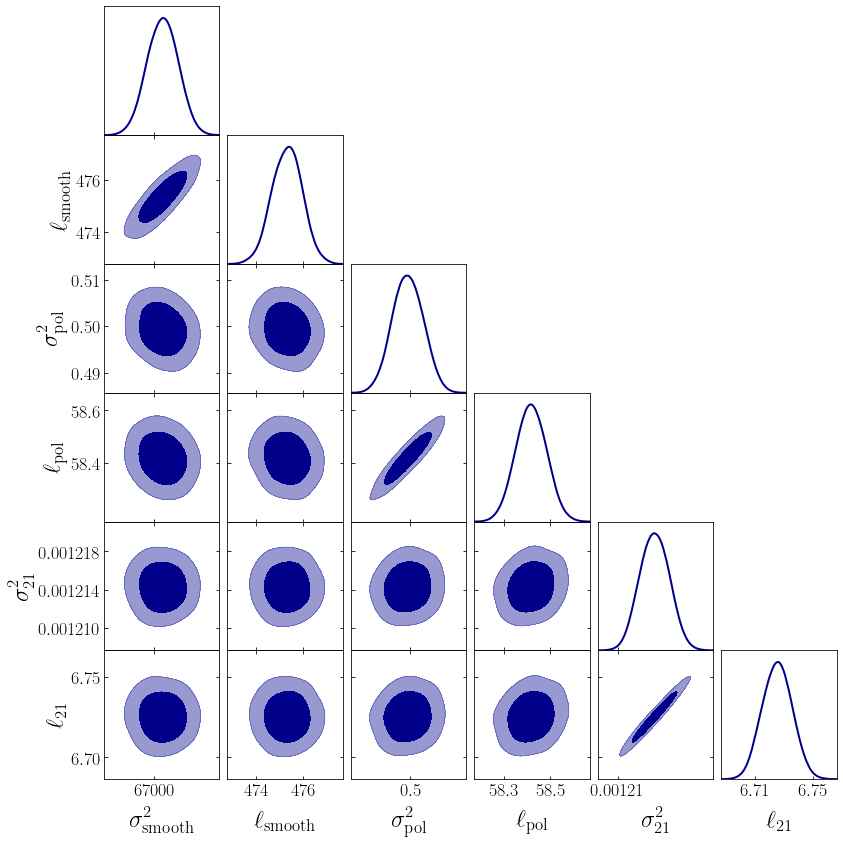

In [15]:
g = plots.get_subplot_plotter()
samples_plot.updateSettings({'contours': [0.68, 0.95]})
g.settings.axes_labelsize=27
g.settings.axes_fontsize=21
g.settings.legend_fontsize=22
g.settings.axis_marker_lw=2
g.settings.axis_marker_ls='dotted'
g.triangle_plot([samples_plot], filled=True,
                legend_loc='upper right',
                line_args=[{'lw':2, 'color':'darkblue'}],
                contour_colors=['darkblue'],fontsize=22)